# Analysis of ShipRSImageNet Dataset for use with POSEIDON

POSEIDON as an augmentation and balancing method works by adding additional instances to each image. The SeaDronesSee v2 dataset that POSEIDON was originally developed for contains drone imagery of bodies of water at various different camera angles. ShipRSImageNet consists of satellite imagery of ships, which is most similar to the top-down perspective shots in SeaDronesSee v2. POSEIDON works well for SeaDronesSea's top-down images due to the fact that the images are largely just open water. However, ShipRSImageNet images contain a lot of land and coast, which may limit how many images we can augment with POSEIDON without masking off the land and ensuring that sufficient open water exists for new instances to be placed. Without doing these steps of masking off land/non-water areas and adding some logic to avoid over-crowding, we would need to limit the use of POSEIDON on ShipRSImageNet to only the images that contain sufficient open water.

Some analysis of the dataset is needed to determine if we can use just the open water images already included in ShipRSImageNet, or if we need to mask off the land and add logic to avoid over-crowding, or as an alternative, source additional open water images from another dataset or source.

In [1]:
import os
import pandas as pd
from shiprsimagenet import ShipRSImageNet

In [2]:
dataset = ShipRSImageNet('ShipRSImageNet_V1')
train_set = dataset.get_image_set('train')

Get a list of all ship instances in the train set

In [3]:
train_objs = [ obj for image in train_set for obj in image.objects ]
len(train_objs)

10860

Determine how many ship instances are in each location, of those that do have their location annotated

In [4]:
pd.Series([ obj.location for obj in train_objs ]).value_counts()

nearland    8959
sea          859
crowd        432
land         340
41 LL         48
river         17
small          4
fog            1
glint          1
Name: count, dtype: int64

Determine how many images contain ships that are at sea. The images with these ships are our best candidates for augmenting since they have good backgrounds to easily place synthetic instances onto, though some of these may still have shorelines that we would need to crop or mask out if we were to use them.

In [5]:
at_sea_images = pd.unique([ obj.filename for obj in train_objs if obj.location == 'sea' ])
len(at_sea_images)

315

Preview some of the images to see what they look like

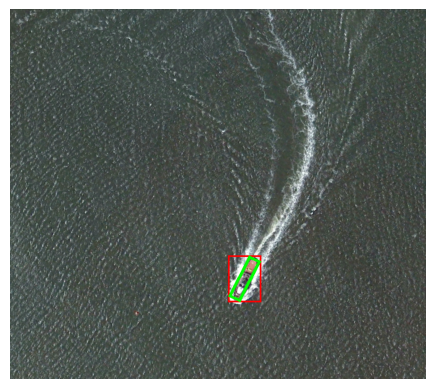

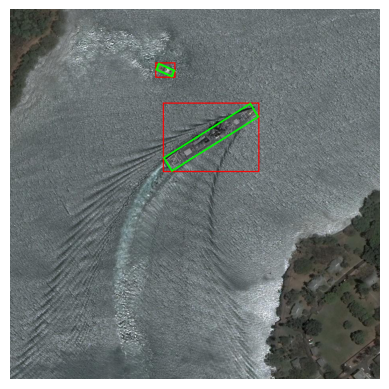

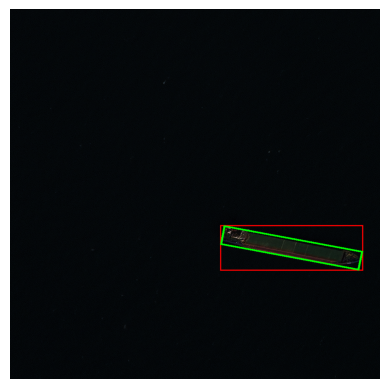

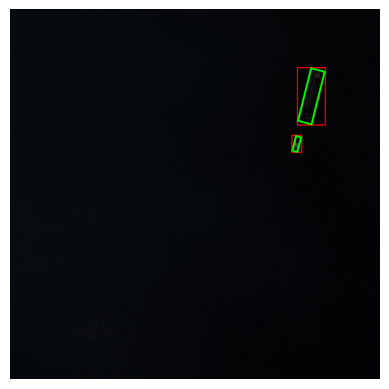

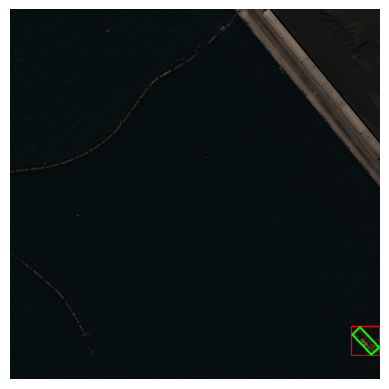

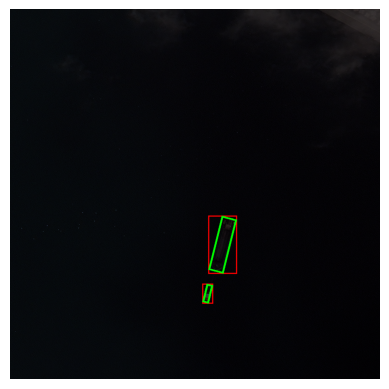

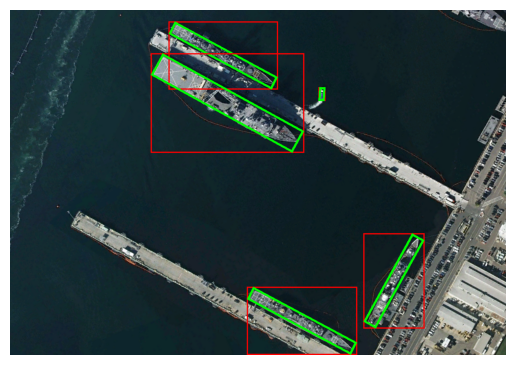

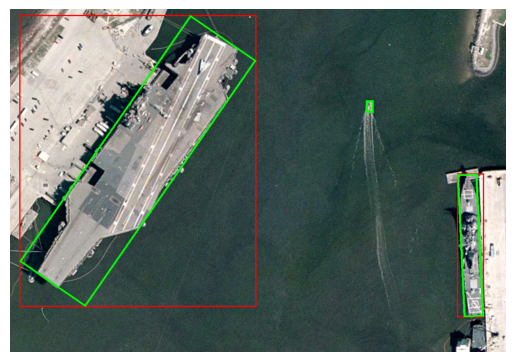

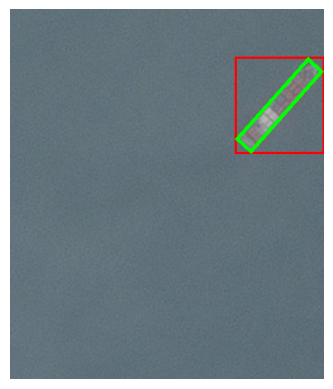

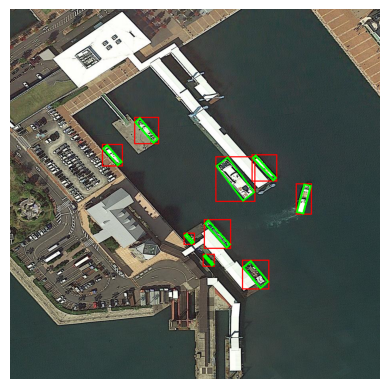

In [6]:
for at_sea_image in at_sea_images[:10]:
    image = dataset.get_image(at_sea_image)
    image.show()

Copy the images to a new directory for further examination of all the images that were identified. It looks like we have a fair amount that may work, though there are certainly a notable number of images that have land that we would need to avoid.

In [7]:
import shutil

for at_sea_image in at_sea_images:
    shutil.copy(dataset.get_image(at_sea_image).file_path, 'augmentation_candidates')

At this point, we can use the `augmentation_candidate_selector.py` script to help us review the candidate images and select the ones that are most suitable for augmentation.

## Review of the candidate images

After reviewing the images that were selected for augmentation, 179 images were selected and are listed in the `selected_for_augmentation.txt` file. These were selected as they contain open water or have a minimal amount of land. The guiding criteria was to select images that had a sufficient amount of open water space avaialble. Some images with large numbers of instances were excluded from augmentation, even if little land or other structures were visible due to the liklihood of synthesized instances being placed on land or other structures in these cases. Whether this is sufficient or not will likely depend on how many instances we will need to add to balance out the dataset in the class of interest. In many images, docks were labeled, so we can ensure that we don't place instances on these areas when we do generate new instances, so that should allow us to be able to effectively use these images for augmentation if they do not also contain a significant amount of land.

A preview of some of the selected images to use as backgrounds to place new instances on are shown below.

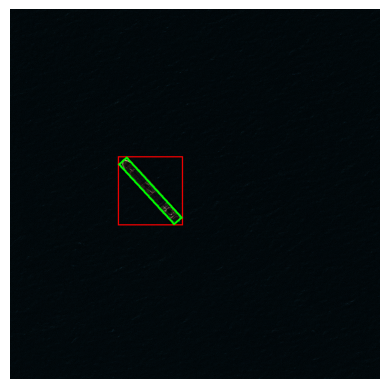

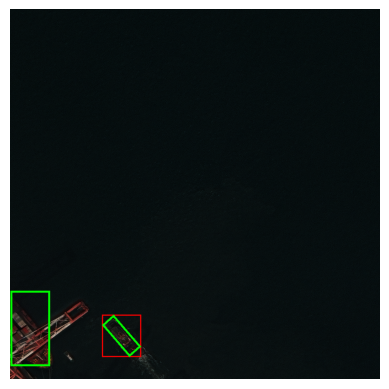

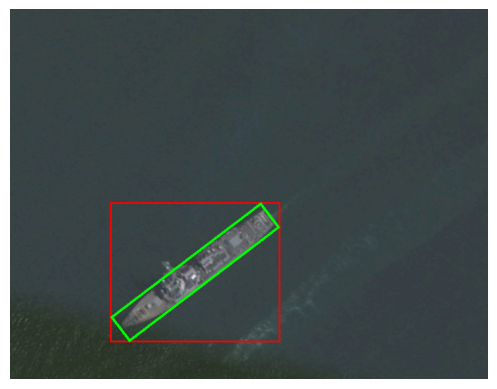

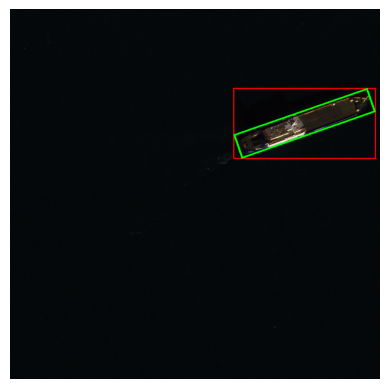

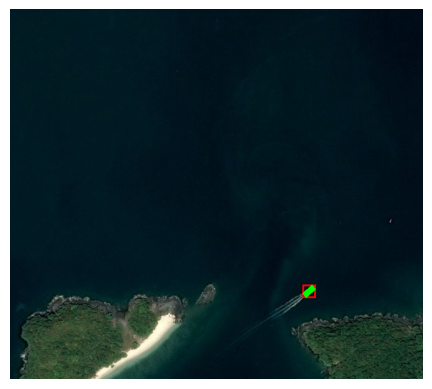

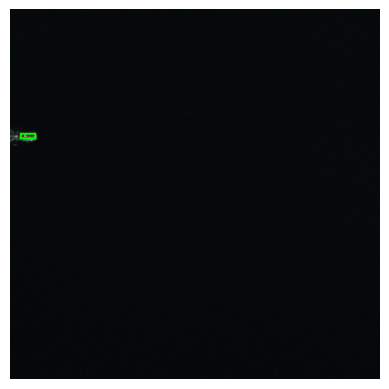

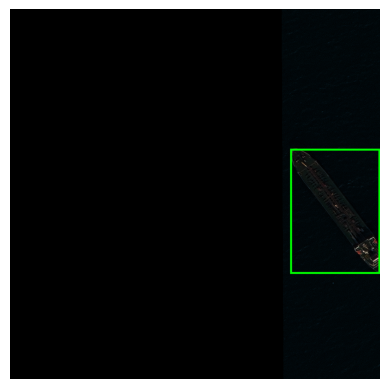

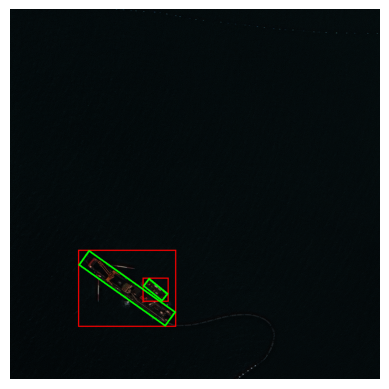

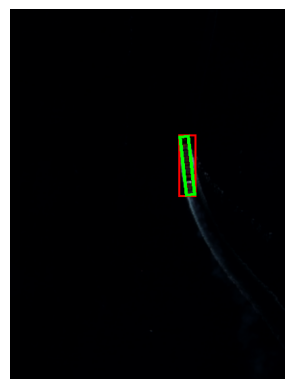

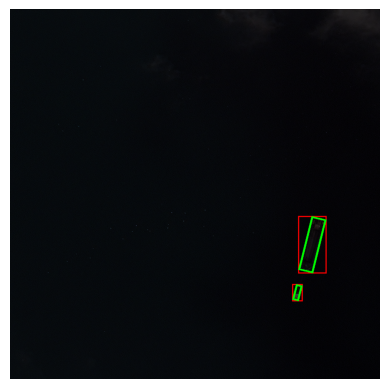

In [8]:
with open('selected_for_augmentation.txt', 'r') as f:
    selected = f.read().splitlines()

images = [ dataset.get_image(image) for image in selected ]

for image in images[:10]:
    image.show()

Let's consider that the class we are trying to balance is the "Fishing Vessel" class in a level 2 classification task for this dataset. According to the paper for ShipRSImageNet, there are 318 instances in the training set. The classes that dominate the training set are the other warships, (around 1000 instances), cargo ships (around 650), motorboat (around 1100), and Submarines (nearly 700).  The fishing vessel class only has 318 instances, so we would probably want to add at least 300 to 600 instances to make it close to the number of instance classes that dominate the training dataset.

We can likely squeeze in an additional 1 - 3 instances in each of the more open images. This would give us up to approximately 3 * 179 = 537 additional instances at most, with a minimum of 179 instances. If we included at least two instances of fishing vessels in each image we are augmenting, that should give us enough additional instances to make the fishing vessel class more prevalent, which could improve model performance for classifying fishing vessels. We will not try to balance every single class, just the ones we are interested in most, since we are most interested in improving performance for one class that is relatively underrepresented. If we do want to balance the classes we are less interested in, we could potentially address the issue with some class weighting during training. We do not have enough suitable images without additional labeling to balance all the classes while avoiding over-crowding in just the ShipRSImageNet dataset alone, though we do still have one way to augment our dataset to potentially improve model performance on the fishing vessel class.

### Normalization Considerations

Since the resolutions of many of the images that were selected for augmentation were quite similar, we may not need to worry about normalization of image resolutions. Some initial testing of the normalization method used in the POSEIDON paper results in reducing the pixel resolution significantly to around 350 x 350, when most of the images are at around 980 or 930 and seem to be similar to each other at first glance. As such, it may make the most sense to just skip normalization, especially since satellite imagery in ShipRSImageNet is already at a lower pixel resolution than the drone imagery in SeaDronesSee v2. It's worth analyzing the resolution information from these selected images to see if normalization is even needed.

In [9]:
image_details = pd.DataFrame([ { 'image_name': os.path.basename(img.file_path), 'source_dataset': img.source_dataset, 'spatial_resolution': img.spatial_resolution, 'width': img.width, 'height': img.height } for img in images ])
image_details

image_name source_dataset spatial_resolution  width  height
0       1327__2363_0.bmp          xView                0.3    930     930
1       1284__2361_0.bmp          xView                0.3    930     930
2          100001203.bmp           HRSC               1.07    822     636
3       2268__1840_0.bmp          xView                0.3    930     930
4          5d99fe851.bmp    Airbus ship               None    664     595
..                   ...            ...                ...    ...     ...
174     1926__1840_0.bmp          xView                0.3    930     930
175     1351__2364_0.bmp          xView                0.3    930     930
176     1379__0_2128.bmp          xView                0.3    930     930
177     1456__1840_0.bmp          xView                0.3    930     930
178  1825__2011_1840.bmp          xView                0.3    930     930

[179 rows x 5 columns]

It looks like many of the images we selected do have the spatial resolution (in meters/pixel) included in the metadata, though some do not. Let's look into how many of the images have this information and what the range of resolutions are.

In [10]:
images_with_spatial_resolution = image_details[image_details['spatial_resolution'].notna()]
images_without_spatial_resolution = image_details[image_details['spatial_resolution'].isna()]

print('Images With Spatial Resolution:')
display(images_with_spatial_resolution.value_counts(['source_dataset', 'spatial_resolution'], dropna=False))
print('Number of Images With Spatial Resolution:', len(images_with_spatial_resolution))

print()

print('Images Without Spatial Resolution:')
display(images_without_spatial_resolution.value_counts(['source_dataset'], dropna=False))
print('Number of Images Without Spatial Resolution:', len(images_without_spatial_resolution))

Images With Spatial Resolution:


source_dataset  spatial_resolution
xView           0.3                   109
HRSC            1.07                   23
NaN             4                       8
                0.92                    1
Name: count, dtype: int64

Number of Images With Spatial Resolution: 141

Images Without Spatial Resolution:


source_dataset
Airbus ship       20
FGSD              18
Name: count, dtype: int64

Number of Images Without Spatial Resolution: 38


Considering that a little less than half of the images have a significantly lower spatial resolution compared to xView's more detailed 0.3m/pixel resolution, it seems like normalization based on spatial resolution will be required since the spatial resolution of a source ship instance could be significantly different from the spatial resolution of the target image.

The Airbus ship dataset images, based on what information I could track down, the images from the Airbus dataset appear to be from Airbus's SPOT satellite, which has a resolution of 1.5 meters per pixel. I could not find an authoritative confirmation of which satellite Airbus used for the dataset, as the dataset is no longer available for download from kaggle, but most articles I found where people were working with the dataset indicated that the images were from SPOT. The paper for FGSD indicates that the resolution of the images range from 0.12 to 1.93 m/pixel. Unfortunately, I never received a response from the FGSD publisher when I reached out to get a copy of this dataset, so I do not have access to the metadata that has the exact resolution for these images, and ShipRSImageNet did not copy over this information in their dataset metadata, so I could probably just get by with assuming a value between the HRSC resolution and the SPOT resolution.

It is probably also worthwhile to see what kind of resolution information we have about images in ShipRSImageNet that countain the source ship instances that we will use for augmentation. Again, we are interested in increasing the prevalence of the fishing vessel class, so we'll look at resolution information for this class.

In [11]:
fishing_vessel_instance_resolutions = pd.DataFrame([ { 'spatial_resolution': image.spatial_resolution, 'source_dataset': image.source_dataset } for image in train_set for obj in image.objects if obj.name == 'Fishing Vessel' ])
fishing_vessel_instance_resolutions.value_counts(['source_dataset', 'spatial_resolution'], dropna=False)

source_dataset  spatial_resolution
xView           0.3                   318
Name: count, dtype: int64

All our images with fishing vessels, which will serve as the source material for new instance generation, comes from the xView dataset, so we know we will have the spatial resolution of each source fishing vessel instance that we use for generation, which will help ensure that we preserve the proper size of ship instances across the different spatial resolutions and can scale the instances to the proper size for the target image.